<a href="https://colab.research.google.com/github/robertomoragad/Estadistica/blob/master/Sim_call_center_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Cargamos librerias
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt

#Modelo de simulacion discreto para centros de atención de clientes

En el presente notebook vamos a compartir un modelo muy sencillo de simulación estocástico, que nos permitirá evaluar y predicir el comportamiento de un centro de atención de clientes. Esto puede ser desde un call center, una tienda física o sucursal, un centro de atención online e incluso un backoffice.

En este modelo existe una demanda de los clientes, por ejemplo para resolver una solicitud técnica o comercial, estos clientes arriban al sistema cada 3 minutos en promedio. Para considerar la variabilidad de este proceso de ingreso, hemos preparado una distribución uniforme con mínimo 2 y máximo 4 minutos.
Estos clientes ingresan a una cola de atención, donde esperan hasta ser atendidos por un agente de soporte. 

El agente de soporte tarda en atender al cliente en promedio 5.25 minutos, para considerar la variabilidad de este proceso de atención, hemos preparado una distribución gamma con parámetros alpha= 2.5 y beta=2.1.

Simularemos durante 120 minutos este sistema y mediremos los siguientes indicadores:

* Cantidad de atenciones realizadas (volumen) en las 2 horas
* Tiempos de espera en la cola promedio, más la distribución completa de  estos tiempos
* Tiempo de atención/soprote promedio, más la distribución completa de  estos tiempos
* Tiempo total de atención (la espera en cola + la atención con el agente) promedio, más la distribución completa de  estos tiempos.

Luego de simular, podremos hacer experimentos que den respuestas a nuestras hipótesis. Por ejemplo: qué pasa si aumentamos en 1 o 2 la cantidad de agentes, y así un sinnúmero de ideas a evaluar.

Nota: No olvidar que en un modelo estocástico se sugiere correr varias veces un intervalo de simulación, una sola réplica nos entregará un resultado muy pobre para nuestra toma de decisión.



<img src='https://drive.google.com/uc?export=view&id=12HA05oxY27vpXLgJWTW4FTgD_oz3fska' width="1000" align="center" style="margin-right: 20px"> 
<br>


<p style="font-size:8pt"> 
Imagen gentileza de: Roberto Moraga</p>

In [4]:
#Inicio

#crear listas para almacenar datasets y su posterior análisis de resultados
wait_times = [] #corresponde al tiempo transcurrido desde que el cliente ingresa a la cola de espera hasta que comienza la atención
support_times = [] #corresponde al tiempo transcurrido desde que el cliente comienza la atención hasta que termina su atención
total_times = [] #corresponde al tiempo transcurrido desde que el cliente ingresa a la cola de espera hasta que sale del call center

RANDOM_SEED = 2 #fijar una semilla para correr 1 replica reproducible

#Creamos parametros del modelo:
NUM_EMPLOYEES = 2     # Number of employees in contact center
#support time with gamma distribution
alpha= 2.5
beta= 2.1
SUPPORT_TIME = alpha * beta  # Minutos promedio para atender a un cliente (soporte)
AVG_CUSTOMER_HOUR = 20 #en promedio llegan 20 clientes por hora a la cola
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada 3 minutos
SIM_TIME = 120        # tiempo de simulación en minutos

customers_handled = 0

class CallCenter(object):
#Un call center tiene un número limitado de agentes (empleados) para atender clientes en paralelo
#Los clientes tienen esperar a uno de los agentes
#Cuando un cliente consigue disponibilidad de un agente, comienza a ser atendido hasta que finaliza la atencion
#este tiempo toma SUPPORT_TIME minutos

    def __init__(self, env, num_employees, support_time):
        self.env = env
        self.staff = simpy.Resource(env, num_employees)
        self.support_time = support_time

    def support(self, customer):
        #Los procesos de atención/soporte atienden a un cliente
        #random_time = max(1, np.random.normal(self.support_time, STD_SUPPORT_TIME))
        #random_time = np.random.gamma(alpha , beta)
        random_time = random.gammavariate(alpha, beta)
        yield self.env.timeout(random_time)
        print(f"Support finished for {customer} at {self.env.now:.2f}")


def customer(env, name, call_center):
    #Los clientes (cada cliente tiene un nombre) arriban al CallCenter y necesitan ser atendidos
    #Luego los clientes comienzan a ser atendidos por un Agente de soporte, esperan hasta
    #que finaliza la atención, y luego dejan/salen del call center (para no volver de nuevo..)  
    
    arrival_time = env.now #guarda el minuto de llegada del cliente
    global customers_handled
    print(f"Customer {name} enters waiting queue at {env.now:.2f}!")
    with call_center.staff.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un agente
        print(f"Customer {name} enters call at {env.now:.2f}")
        start_support_time = env.now #guarda el minuto en que se inicia la atención del cliente 
        wait_times.append(env.now - arrival_time) #calcula el tiempo de espera en la cola
        
        yield env.process(call_center.support(name))
        # Cliente sale/deja el CallCenter
        print(f"Customer {name} left call at {env.now:.2f}")
        customers_handled += 1       
        support_times.append(env.now - start_support_time) #calcula el tiempo de atención
        total_times.append(env.now - arrival_time) #calcula el tiempo total (espera + atención)


def setup(env, num_employees, support_time, customer_interval):
#Crea un Call Center, un número inicial de clientes y luego se mantendrá creando clientes cada "CUSTOMER_INTERVAL" minutos
    #Crea el call center
    call_center = CallCenter(env, num_employees, support_time)

    #Crea 5 clientes iniciales
    for i in range(1, 6):
        env.process(customer(env, i, call_center))

    #crea más clientes mientras la simulaciíon está corriendo
    while True:
        #yield env.timeout(random.randint(customer_interval - 1, customer_interval + 1 ))
        yield env.timeout(random.uniform(customer_interval - 1, customer_interval + 1))
        i += 1
        env.process(customer(env, i, call_center))


# Setup and start the simulation  
print("Starting Call Center Simulation")
random.seed(RANDOM_SEED)  #esto nos ayudará a reproducir los resultados

# Crea un environment e inicia el proceso setup
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES, SUPPORT_TIME, CUSTOMER_INTERVAL))

# Execute!
env.run(until=SIM_TIME)

print("Customer handled: " + str(customers_handled))


Starting Call Center Simulation
Customer 1 enters waiting queue at 0.00!
Customer 2 enters waiting queue at 0.00!
Customer 3 enters waiting queue at 0.00!
Customer 4 enters waiting queue at 0.00!
Customer 5 enters waiting queue at 0.00!
Customer 1 enters call at 0.00
Customer 2 enters call at 0.00
Support finished for 1 at 1.60
Customer 1 left call at 1.60
Customer 3 enters call at 1.60
Customer 6 enters waiting queue at 3.91!
Support finished for 3 at 5.10
Customer 3 left call at 5.10
Customer 4 enters call at 5.10
Customer 7 enters waiting queue at 7.13!
Support finished for 2 at 8.77
Customer 2 left call at 8.77
Customer 5 enters call at 8.77
Customer 8 enters waiting queue at 9.99!
Support finished for 4 at 11.29
Customer 4 left call at 11.29
Customer 6 enters call at 11.29
Support finished for 5 at 12.99
Customer 5 left call at 12.99
Customer 7 enters call at 12.99
Customer 9 enters waiting queue at 13.98!
Support finished for 6 at 15.99
Customer 6 left call at 15.99
Customer 8 en

[0, 0, 1.598823732860909, 5.10247298760057, 8.765217743622761, 7.375157351677558, 5.86861911411113, 5.999854823666787, 3.9111029681147027, 4.795175410517487, 3.1314062828654556, 2.202095870725575, 5.247423510519852, 5.317944338812239, 6.935017509030786, 4.846494081384485, 5.852241122366898, 11.348767434188218, 7.732505348357627, 7.407308210305054, 5.817325332504851, 6.653634196717782, 6.975895712521115, 5.851171399454813, 4.371565541694913, 3.96692791087267, 3.9376419887380507, 3.792799382883402, 1.9461480046816462, 2.414962572820258, 0.0, 0.6765857518246179, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7965913807929894, 2.017949086285668, 1.035801848182345, 0.0, 0.0, 0.0, 1.9578006618424126, 0.822506333265423]
Tamaño:  45
Media:  3.521620776573579
Sigma:  2.919360224345057


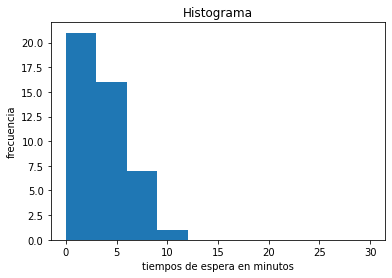

In [5]:
#Crear graficas de Tiempos de espera

print(wait_times) #dataset tiempos de espera
print('Tamaño: ',np.size(wait_times)) #tamaño muestra
print('Media: ',np.mean(wait_times)) #media
print('Sigma: ',np.std(wait_times)) #desv. std

plt.hist(wait_times, bins=10, range= (0, 30))
plt.ylabel('frecuencia')
plt.xlabel('tiempos de espera en minutos')
plt.title('Histograma')
plt.show()

[1.598823732860909, 3.5036492547396607, 8.765217743622761, 6.184752907855487, 4.2290733815485435, 4.699640219853443, 4.893462260485595, 3.644102286204209, 5.928936587181141, 2.4750843101640534, 8.729984762172077, 9.416942266613152, 5.5790263163628, 9.191411068176052, 4.855411185171555, 8.498208437082631, 14.412308382645108, 2.342823676482716, 3.1777764936670394, 5.294803750091006, 7.176839906055669, 1.498964336035698, 5.376383193053904, 2.8418925426294948, 7.200536286765427, 5.490302012256379, 2.710701937172672, 3.957662442654282, 0.8465984847537698, 7.527687114060171, 3.077083700241161, 2.4908362525228256, 1.1150275453618974, 1.018472117435607, 3.744770598298274, 9.497938222477643, 9.23267968308727, 4.971557744804912, 3.5709359502720446, 2.1518059067565076, 6.232661825662646, 6.512059946596665, 0.9782676630694027]
Tamaño:  43
Media:  5.03821173104661
Sigma:  2.9309202832681316


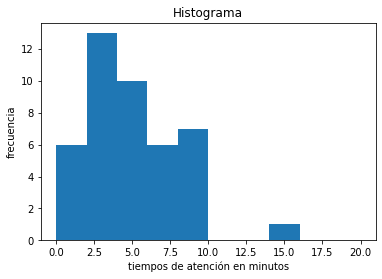

In [9]:
#Crear graficas de Tiempos de atención (solo el tiempo con ejecutivo)

print(support_times) #dataset tiempos de atencion
print('Tamaño: ',np.size(support_times)) #tamaño muestra
print('Media: ',np.mean(support_times)) #media
print('Sigma: ',np.std(support_times)) #desv. std

plt.hist(support_times, bins=10, range= (0, 20))
plt.ylabel('frecuencia')
plt.xlabel('tiempos de atención en minutos')
plt.title('Histograma')
plt.show()

[1.598823732860909, 5.10247298760057, 8.765217743622761, 11.287225895456057, 12.994291125171305, 12.074797571531, 10.762081374596725, 7.555205254318912, 11.928791410847928, 7.2702597206815405, 11.861391045037532, 11.619038137338727, 10.89697065517504, 14.438834578695904, 9.70190526655604, 14.35044955944953, 21.347325891675894, 13.691591110670934, 10.910281842024666, 12.70211196039606, 12.99416523856052, 8.474860048556813, 12.030017389771686, 7.213458084324408, 13.05170768622024, 9.457229923129049, 6.648343925910723, 7.750461825537684, 3.2615610575740277, 9.473835118741817, 3.077083700241161, 3.1674220043474435, 1.1150275453618974, 1.018472117435607, 3.744770598298274, 9.497938222477643, 9.23267968308727, 7.768149125597901, 5.588885036557713, 2.1518059067565076, 7.268463673844991, 6.512059946596665, 2.9360683249118154]
Tamaño:  43
Media:  8.704500768547671
Sigma:  4.3058094542354235


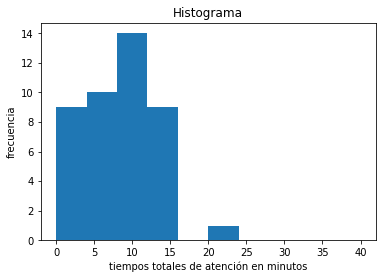

In [10]:
#Crear graficas de Tiempos totales de atención (espera + atención)

print(total_times) #dataset tiempos totales de atencion
print('Tamaño: ',np.size(total_times)) #tamaño muestra
print('Media: ',np.mean(total_times)) #media
print('Sigma: ',np.std(total_times)) #desv. std

plt.hist(total_times, bins=10, range= (0, 40))
plt.ylabel('frecuencia')
plt.xlabel('tiempos totales de atención en minutos')
plt.title('Histograma')
plt.show()

In [8]:
utilizacion = sum(support_times) / (NUM_EMPLOYEES * SIM_TIME)
print("Utilización del sistema: ", utilizacion)

Utilización del sistema:  0.9026796018125179


### aquí tus preguntas para evaluar ajustes al modelo:

* qué pasa sí ....
* ...